<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузим-и-изучим-данные" data-toc-modified-id="Загрузим-и-изучим-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузим и изучим данные</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разобьем-данные-на-выборки" data-toc-modified-id="Разобьем-данные-на-выборки-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Разобьем данные на выборки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Линейная регрессия</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Визуализация-предсказания" data-toc-modified-id="Визуализация-предсказания-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Визуализация предсказания</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

### Загрузим и изучим данные

Загрузим данные

In [2]:
taxi = pd.read_csv('./datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi.info()
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Ресемплирование

Выполним ресемплирование по одному часу

In [4]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Загрузили данные. Выполним ресемплирование по одному часу 

## Анализ

<AxesSubplot:title={'center':'Количество заказов по часам'}, xlabel='Дата', ylabel='Количество заказов'>

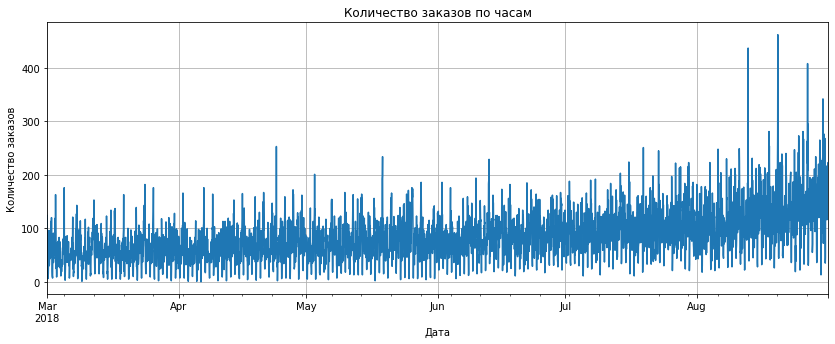

In [5]:
taxi.plot(
    title='Количество заказов по часам', 
    legend=False, 
    figsize=(14,5), 
    grid=True, 
    xlabel='Дата', 
    ylabel='Количество заказов'
)

### Тренды и сезонность

Разложим временной ряд на три составляющие: тренд, сезонность и остаток

In [6]:
decomposed = seasonal_decompose(taxi)

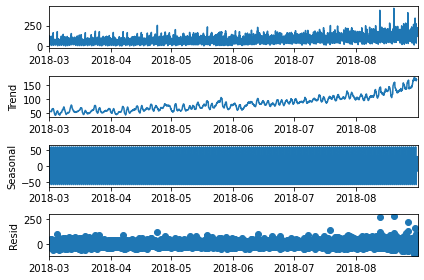

In [7]:
decomposed.plot()
plt.show()

Посмотрим на данные за день, неделю и месяц. За период возьмем первые числа марта. Для построения графиков создадим функцию **decompose()**

In [8]:
def decompose(result, time_1, time_2, title, figsize = (14,5)):
    if result == 'trend':
        decomposed.trend[time_1 : time_2].plot(
            title = title, 
            legend = False, 
            figsize = figsize, 
            grid = True, 
            xlabel = 'Период', 
            ylabel = 'Количество заказов'
        )
    else:
        decomposed.seasonal[time_1 : time_2].plot(
            title = title, 
            legend = False, 
            figsize = figsize, 
            grid = True, 
            xlabel = 'Период', 
            ylabel = 'Количество заказов'
        )

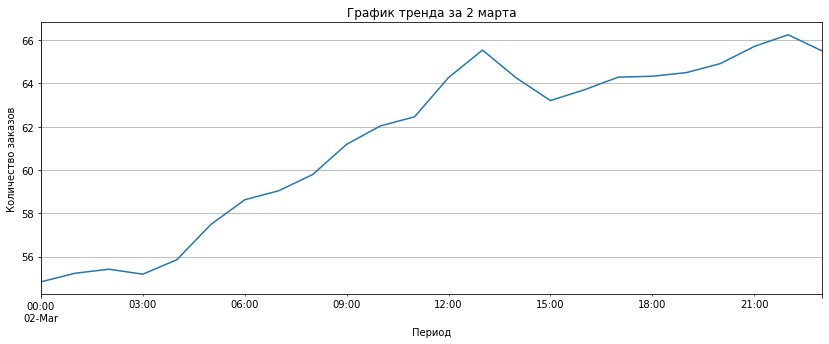

In [9]:
decompose('trend', '2018-03-02', '2018-03-02', 'График тренда за 2 марта')

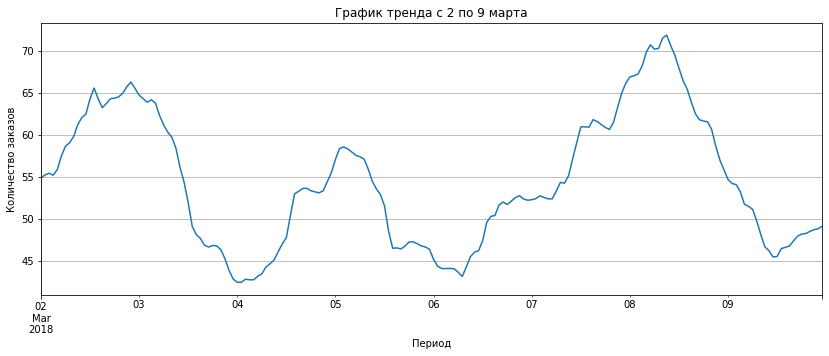

In [10]:
decompose('trend', '2018-03-02', '2018-03-09', 'График тренда с 2 по 9 марта')

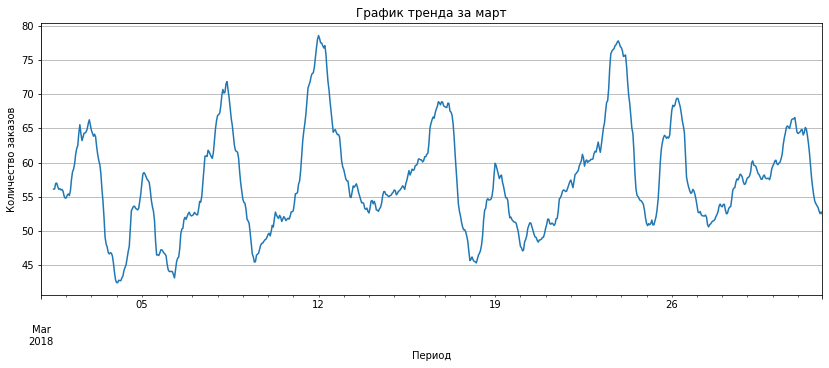

In [11]:
decompose('trend', '2018-03-01', '2018-03-31', 'График тренда за март')

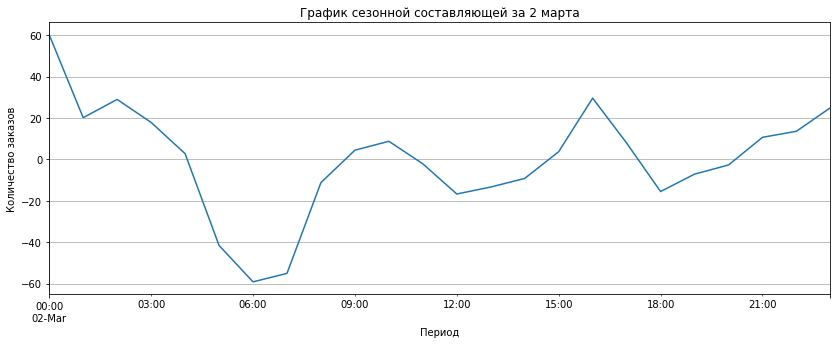

In [12]:
decompose('seasonal', '2018-03-02', '2018-03-02', 'График сезонной составляющей за 2 марта')

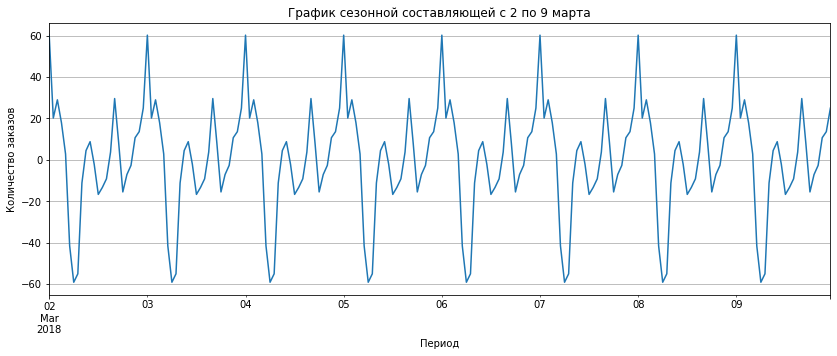

In [13]:
decompose('seasonal', '2018-03-02', '2018-03-09', 'График сезонной составляющей с 2 по 9 марта')

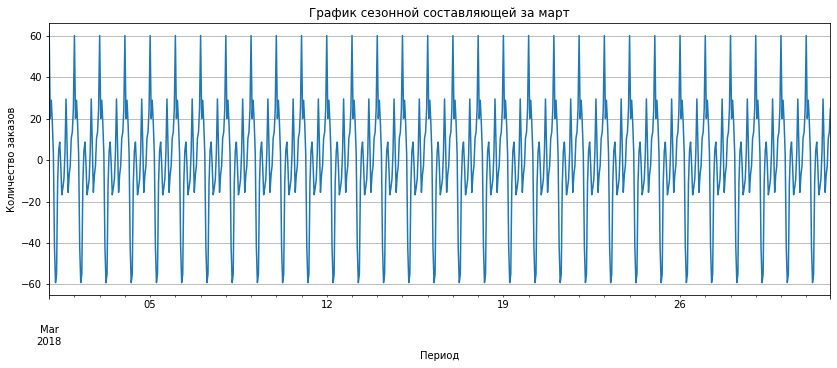

In [14]:
decompose('seasonal', '2018-03-01', '2018-03-31', 'График сезонной составляющей за март')

Как видно из данных в течение суток, количество заказов увеличивается ближе к ночи, возможно это связанно, что в вечернее время уже не ходит общественный транспорт и чаще приходится заказывать такси. 

При анализе за неделю и месяц, наблюдается увеличение заказов в некоторые дни недели, это может быть связанно, что в эти дни больше рейсов.

За весь период анализа данных, заметен рост количества заказов. Это может быть связанно с увеличение популярности таксопарка или увеличение количества рейсов в период отпусков.

### Создание признаков

Создадим функцию **make_features()**, чтобы прибавить к таблице новые календарные признаки: месяц, день и день недели.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    return data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [16]:
taxi['rolling_mean'] = make_features(taxi, 30, 40)

### Разобьем данные на выборки

Разделим исходные данные на обучающую и тестовую выборки.

In [17]:
train, test = train_test_split(taxi, shuffle=False, test_size = 0.1)
train = train.dropna()

print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (3934, 35)
Размер тестовой выборки: (442, 35)


В выборке выделим признаки и целевой признак

In [18]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## Обучение

In [19]:
best_model = pd.DataFrame({'Model': [], 'RMSE': []}) 

### Дерево решений

In [20]:
%%time

tscv = TimeSeriesSplit(n_splits=10)
regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(1, 20)]
hyperparams = [{'criterion':['squared_error'], 'max_depth':max_depth_list, 'random_state':[12345]}]

cv = GridSearchCV(regressor, hyperparams, cv = tscv, verbose=1, scoring='neg_mean_squared_error')
cv.fit(features_train,target_train)

best_factor_dt = cv.best_estimator_

print()
print('Лучшая модель дерева решений:')
print(best_factor_dt, '  RMSE:', (cv.best_score_*-1)** 0.5)
print()
means = cv.cv_results_['mean_test_score']
for mean, params in zip(means, cv.cv_results_['params']):
    print("%0.2f for %s"% ((mean*-1)** 0.5, params))
print()

best_model = best_model.append({'Model': best_factor_dt, 'RMSE': (cv.best_score_*-1)** 0.5}, ignore_index=True)

Fitting 10 folds for each of 19 candidates, totalling 190 fits

Лучшая модель дерева решений:
DecisionTreeRegressor(max_depth=4, random_state=12345)   RMSE: 30.240808751020815

34.47 for {'criterion': 'squared_error', 'max_depth': 1, 'random_state': 12345}
31.76 for {'criterion': 'squared_error', 'max_depth': 2, 'random_state': 12345}
30.72 for {'criterion': 'squared_error', 'max_depth': 3, 'random_state': 12345}
30.24 for {'criterion': 'squared_error', 'max_depth': 4, 'random_state': 12345}
30.31 for {'criterion': 'squared_error', 'max_depth': 5, 'random_state': 12345}
30.81 for {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 12345}
31.24 for {'criterion': 'squared_error', 'max_depth': 7, 'random_state': 12345}
32.03 for {'criterion': 'squared_error', 'max_depth': 8, 'random_state': 12345}
33.72 for {'criterion': 'squared_error', 'max_depth': 9, 'random_state': 12345}
34.03 for {'criterion': 'squared_error', 'max_depth': 10, 'random_state': 12345}
34.79 for {'criterion'

### Случайный лес

In [21]:
%%time

regressor = RandomForestRegressor() 
max_depth_list = [x for x in range(1, 11)]
max_estimators = [x for x in range(1, 92, 10)] 
hyperparams = [{'criterion':['squared_error'], 'max_depth':max_depth_list, 'n_estimators':max_estimators, 'random_state':[12345]}]

cv = GridSearchCV(regressor, hyperparams, cv = tscv, verbose=1, scoring='neg_mean_squared_error')
cv.fit(features_train,target_train)

best_factor_rf = cv.best_estimator_

print()
print('Лучшая модель дерева решений:')
print(best_factor_rf, '  RMSE:', (cv.best_score_*-1)** 0.5)
print()
means = cv.cv_results_['mean_test_score']
for mean, params in zip(means, cv.cv_results_['params']):
    print("%0.2f for %s"% ((mean*-1)** 0.5, params))
print()

best_model = best_model.append({'Model': 'RandomForestRegressor()', 'RMSE': (cv.best_score_*-1)** 0.5}, ignore_index=True)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Лучшая модель дерева решений:
RandomForestRegressor(max_depth=10, n_estimators=91, random_state=12345)   RMSE: 25.30808002980388

34.61 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 1, 'random_state': 12345}
33.72 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 11, 'random_state': 12345}
33.75 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 21, 'random_state': 12345}
33.78 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 31, 'random_state': 12345}
33.81 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 41, 'random_state': 12345}
33.82 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 51, 'random_state': 12345}
33.83 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 61, 'random_state': 12345}
33.85 for {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 71, 'random_state': 12345}
33.84

### CatBoost

In [22]:
%%time
tscv = TimeSeriesSplit(n_splits=2)
regressor = CatBoostRegressor() 
max_iterations_list = [x for x in  range(1, 52, 10)]
max_depth_list = [x for x in range (1, 10)]
hyperparams = [{'max_depth':max_depth_list, 'iterations':max_iterations_list}]

cv = GridSearchCV(regressor, hyperparams, cv = tscv, verbose=1, scoring='neg_mean_squared_error')
cv.fit(features_train, target_train, verbose=False)

best_factor_cat = cv.best_estimator_
print()
print('Лучшая модель дерева решений:')
print(best_factor_rf, '  RMSE:', (cv.best_score_*-1)** 0.5)
print()

means = cv.cv_results_['mean_test_score']
for mean, params in zip(means, cv.cv_results_['params']):
    print("%0.2f for %s"% ((mean*-1)** 0.5, params))
print()

best_model = best_model.append({'Model': 'CatBoostRegressor()', 'RMSE': (cv.best_score_*-1)** 0.5}, ignore_index=True)

Fitting 2 folds for each of 54 candidates, totalling 108 fits

Лучшая модель дерева решений:
RandomForestRegressor(max_depth=10, n_estimators=91, random_state=12345)   RMSE: 29.03793434233218

41.75 for {'iterations': 1, 'max_depth': 1}
39.12 for {'iterations': 1, 'max_depth': 2}
37.54 for {'iterations': 1, 'max_depth': 3}
37.67 for {'iterations': 1, 'max_depth': 4}
37.57 for {'iterations': 1, 'max_depth': 5}
37.34 for {'iterations': 1, 'max_depth': 6}
37.60 for {'iterations': 1, 'max_depth': 7}
38.42 for {'iterations': 1, 'max_depth': 8}
39.20 for {'iterations': 1, 'max_depth': 9}
32.19 for {'iterations': 11, 'max_depth': 1}
30.58 for {'iterations': 11, 'max_depth': 2}
29.83 for {'iterations': 11, 'max_depth': 3}
29.89 for {'iterations': 11, 'max_depth': 4}
30.09 for {'iterations': 11, 'max_depth': 5}
29.80 for {'iterations': 11, 'max_depth': 6}
30.49 for {'iterations': 11, 'max_depth': 7}
30.07 for {'iterations': 11, 'max_depth': 8}
30.75 for {'iterations': 11, 'max_depth': 9}
31.17 

### LGBMRegressor

In [23]:
%%time

regressor = LGBMRegressor() 
max_estimators_list = [x for x in  range(10, 101, 20)]
max_depth_list = [x for x in range (4, 11)]
hyperparams = [{'max_depth':max_depth_list, 'n_estimators':max_estimators_list, 'learning_rate' : [0.03, 0.1],
               'num_leaves': [18, 21, 27], 'random_state':[12345]}]

cv = GridSearchCV(regressor, hyperparams, cv = 2, verbose=1, scoring='neg_mean_squared_error')
cv.fit(features_train, target_train)

best_factor_lgb = cv.best_estimator_

print()
print('Лучшая модель LGBMRegressor:')
print(cv.best_params_, '  RMSE:', (cv.best_score_*-1)** 0.5)
print()
means = cv.cv_results_['mean_test_score']
for mean, params in zip(means, cv.cv_results_['params']):
    print("%0.2f for %s"% ((mean*-1)** 0.5, params))
print()

best_model = best_model.append({'Model': best_factor_lgb, 'RMSE': (cv.best_score_*-1)** 0.5}, ignore_index=True)

Fitting 2 folds for each of 210 candidates, totalling 420 fits

Лучшая модель LGBMRegressor:
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 70, 'num_leaves': 21, 'random_state': 12345}   RMSE: 27.329773864172203

41.35 for {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 10, 'num_leaves': 18, 'random_state': 12345}
41.35 for {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 10, 'num_leaves': 21, 'random_state': 12345}
41.35 for {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 10, 'num_leaves': 27, 'random_state': 12345}
35.14 for {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 30, 'num_leaves': 18, 'random_state': 12345}
35.14 for {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 30, 'num_leaves': 21, 'random_state': 12345}
35.14 for {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 30, 'num_leaves': 27, 'random_state': 12345}
31.92 for {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 50, 'num_leaves': 18, 'random_state': 12345}
31

### Линейная регрессия

In [24]:
linear = cross_val_score(
    LinearRegression(),
    features_train,
    target_train,
    scoring = 'neg_mean_squared_error',
    cv = 5).mean()

print('RMSE линейной модели:', (linear*-1)**0.5)

best_model = best_model.append({'Model': 'LinearRegression()', 'RMSE': (linear*-1)**0.5}, ignore_index=True)

RMSE линейной модели: 25.94589473813044


## Тестирование

In [25]:
best_model = best_model.set_index('Model')

In [27]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

best_model.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)

,RMSE
Model,
"DecisionTreeRegressor(max_depth=4, random_state=12345)",30.240809
RandomForestRegressor(),25.308080
CatBoostRegressor(),29.037934
"LGBMRegressor(max_depth=9, n_estimators=70, num_leaves=21, random_state=12345)",27.329774
LinearRegression(),25.945895


Протестируем лучшую модель

In [28]:
model = best_factor_rf
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
rmse = mean_squared_error(target_test, predicted_valid)

print('Итоговая метрика:', rmse**0.5)

Итоговая метрика: 44.05820283921083


### Визуализация предсказания

Отобразим финальные предсказания на графике: графики исходного и предсказанных данных.

In [30]:
true_pred = pd.DataFrame({ 
    'y_true' : target_test,
    'y_pred' : best_factor_rf.predict(features_test)
    }).sort_index()

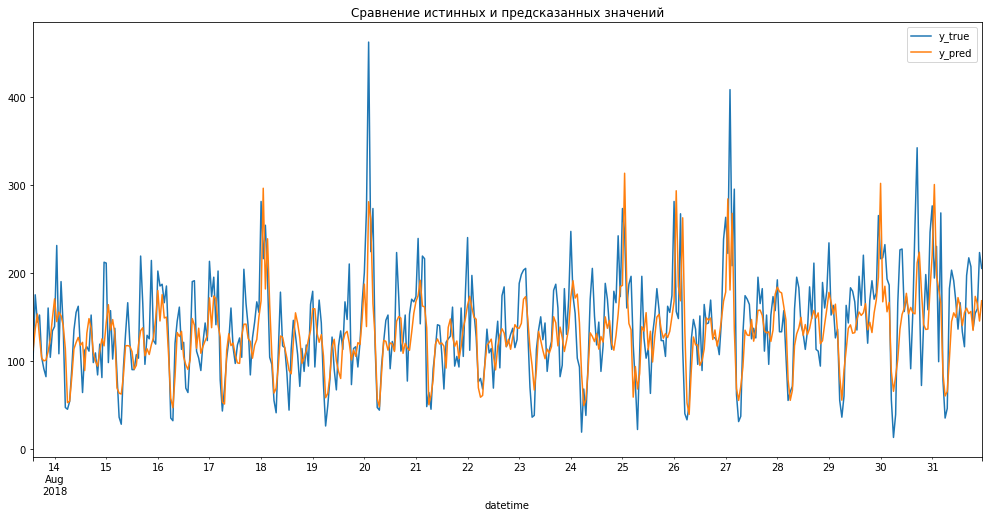

In [31]:
true_pred.plot(figsize=(17,8), title='Сравнение истинных и предсказанных значений');

По графику видно, что модель не плохо определяет количество заказов такси в аэропортах

### Вывод

Провели анализ заказов такси в аэропортах. Выполнили ресемплирование по одному часу. Создали признаки для анализа данных. Обучили разные модели с различными гиперпараметрами. Наименьшее RMSE у модели **RandomForestRegressor(max_depth=10, n_estimators=91, random_state=12345)** и равно 44